# Prerank GSEA for assayable biological processes
> Biological processes mapped to assays

- toc: true 
- badges: true
- comments: true
- categories: [useful_resources]
- image: images/chart-preview.png

Whilst it often useful to use [GeneOntology](http://geneontology.org/)'s biological processes to approximate the pathomechanisms of a disease, one frequently finds themself whittling through a list of enriched biological processes, trying to find a process that is actually assayable.

Fortunately, living deep within the Supplementary Material of a Nature [paper](https://www.nature.com/articles/ng.3259#MOESM9), lives a curated list of  processes **testable through specific molecular experiments**.

Let's install gseapy and download the data.

In [96]:
!pip install gseapy
!wget https://static-content.springer.com/esm/art%3A10.1038%2Fng.3259/MediaObjects/41588_2015_BFng3259_MOESM9_ESM.xlsx
!mv 41588_2015_BFng3259_MOESM9_ESM.xlsx processes.xlsx
!wget https://static-content.springer.com/esm/art%3A10.1038%2Fng.3259/MediaObjects/41588_2015_BFng3259_MOESM12_ESM.xlsx
!mv 41588_2015_BFng3259_MOESM12_ESM.xlsx tissue_go_mapping.xlsx
!wget https://raw.githubusercontent.com/finlayiainmaclean/datadump/main/EFO_0000342-associated-diseases.csv
!curl -OL https://github.com/finlayiainmaclean/datadump/blob/main/genego.tab.zip?raw=true
!unzip genego.tab.zip?raw=true

In [95]:
import gseapy as gp
import pandas as pd
import numpy as np

In [103]:
gene2go.go.nunique(), len(processes)

(12248, 973)

There are 973 testable processes out of 12248.. Not that many..

In [97]:
processes = pd.read_excel('processes.xlsx', skiprows=1)
processes

,GO Term Name,GO Term ID
0,abscisic_acid_mediated_signaling_pathway,GO:0009738
1,abscisic_acid_metabolic_process,GO:0009687
2,acetyl_coa_biosynthetic_process_from_acetate,GO:0019427
3,acetylcholine_transport,GO:0015870
4,actin_cytoskeleton_reorganization,GO:0031532
...,...,...
968,xanthophyll_metabolic_process,GO:0016122
969,xenobiotic_metabolic_process,GO:0006805
970,xylan_catabolic_process,GO:0045493
971,xylem_and_phloem_pattern_formation,GO:0010051


The paper also mapped tissues to biological processes via first using co-occurences, and then manually curating the list.

In [5]:
tissue_mapping = pd.read_excel('tissue_go_mapping.xlsx', skiprows=1).set_index('BRENDA Tissue ID')
bto2name = dict(zip(tissue_mapping.index, tissue_mapping.Tissue))

go2bto = {}
for bto, row in tissue_mapping.drop(columns=['Tissue']).iterrows():
  for go in row:
    if go is None:
      break
    go2bto[go] = bto

Let's run a prerank gene set enrichment analysis, using only testable biological processes. First we need to generate a geneset.

In [14]:
genego = pd.read_csv('genego.tab',sep='\t')
gene2go = []
go2name = {}
for row in genego.dropna(subset=['Gene ontology (biological process)']).itertuples():
  for _go in row[4].split('; '):
    go = _go.split('[')[1].replace(']','')
    name = _go.split(' [')[0]
    gene2go.append((row[2], go))
    go2name[go] = name

gene2go = pd.DataFrame(gene2go,columns =['gene','go'])
gene2go_dict = gene2go.groupby('go')['gene'].apply(list).to_dict()
gene2go_testable_dict = dict([(i, gene2go_dict[i]) for i in np.intersect1d(processes['GO Term ID'], gene2go.go)])

Let's run the prerankGSEA for chronic pancreatitis genes, defined by the overall association score in OpenTargets.

In [7]:
cp_targets = pd.read_csv('EFO_0000342-associated-diseases.csv')
cp_targets.head(5)

,symbol,overallAssociationScore,geneticAssociations,somaticMutations,drugs,pathwaysSystemsBiology,textMining,rnaExpression,animalModels,targetName
0,PRSS1,0.834384,0.9183390021590296,No data,No data,No data,0.1838682865290527,No data,0.5693580106773287,serine protease 1
1,SPINK1,0.804783,0.8862311248507138,No data,No data,No data,0.23856390277427408,No data,0.3298784490540059,serine peptidase inhibitor Kazal type 1
2,CTRC,0.740035,0.8910696416923192,No data,No data,No data,0.09941106709313025,No data,0.29290105828927904,chymotrypsin C
3,CFTR,0.696968,0.9074161629304885,No data,No data,No data,0.2678564156117781,No data,0.3978335055391351,CF transmembrane conductance regulator
4,VDR,0.369580,No data,No data,0.607930797611621,No data,No data,No data,No data,vitamin D receptor


Running the enrichment, we see calcium-mediated signaling as one of the most enriched testable processes.

In [29]:
pre_res = gp.prerank(rnk=cp_targets[['symbol','overallAssociationScore']].copy(), gene_sets=gene2go_testable_dict.copy(),
                     processes=2,
                     permutation_num=500, # reduce number to speed up testing
                     outdir='prerank_report', format='png', seed=6)
pre_res = pd.read_csv('prerank_report/gseapy.prerank.gene_sets.report.csv')
pre_res['go_name'] = pre_res.Term.apply(go2name.get)
#Map tissue
pre_res['bto'] = pre_res.Term.apply(go2bto.get)
pre_res['tissue_name'] = pre_res.bto.apply(bto2name.get)
pre_res = pre_res.sort_values(by='es',ascending=False)
pre_res.head(10)


,Term,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes,go_name,bto,tissue_name
0,GO:0006367,0.827233,1.431275,0.016000,0.220365,140,17,VDR;NR3C1;CREBBP;CCN2;PGR;THRA;PPARG;E2F2;NR4A...,VDR;NR3C1;CREBBP;CCN2;PGR;THRA,transcription initiation from RNA polymerase I...,None,None
4,GO:0006919,0.742733,1.288945,0.068000,0.846401,89,21,CDKN2A;NGFR;S100A9;NGF;EIF2AK3;NLRP1;BAD;PPARG...,CDKN2A;NGFR;S100A9;NGF;EIF2AK3;NLRP1;BAD,activation of cysteine-type endopeptidase acti...,None,None
1,GO:0016579,0.736472,1.287383,0.062000,0.577623,265,25,CFTR;SMAD4;IL33;PTEN;TP53;BAP1;CYLD;HIF1A;MYC;...,CFTR;SMAD4,protein deubiquitination,None,None
3,GO:0009749,0.720428,1.247147,0.122000,0.618023,62,18,SLC8A1;CCN2;ILDR2;GIPR;BAD;PTEN;NEUROD1;MAFA;R...,SLC8A1;CCN2;ILDR2;GIPR;BAD;PTEN;NEUROD1;MAFA;R...,response to glucose,None,None
2,GO:0042593,0.695962,1.227794,0.060000,0.577756,104,37,NGFR;PDX1;BHLHA15;GCK;INS;LEP;GCGR;WFS1;LEPR;C...,NGFR;PDX1;BHLHA15;GCK;INS;LEP;GCGR;WFS1;LEPR;C...,glucose homeostasis,None,None
5,GO:0019722,0.664942,1.138633,0.197581,0.944897,71,17,CXCR2;CXCR1;BHLHA15;EIF2AK3;PDPK1;CHRM3;TRPM4;...,CXCR2;CXCR1;BHLHA15;EIF2AK3;PDPK1;CHRM3,calcium-mediated signaling,None,None
6,GO:0050821,0.636343,1.112191,0.252505,0.976760,197,21,CDKN2A;WFS1;PTEN;TP53;CDKN1A;CHEK2;SMAD3;PARK7...,CDKN2A;WFS1;PTEN;TP53;CDKN1A,protein stabilization,None,None
8,GO:0001666,0.603386,1.069221,0.310000,1.000000,157,36,SMAD4;CREBBP;LEP;TLR2;CD38;NF1;HIF1A;EGR1;REG1...,SMAD4;CREBBP;LEP;TLR2;CD38,response to hypoxia,None,None
9,GO:0016567,0.600506,1.053758,0.344000,1.000000,414,21,CRBN;DDB1;RBX1;CUL4A;FEM1B;SMURF1;CUL9;SOCS1;H...,CRBN;DDB1;RBX1;CUL4A;FEM1B;SMURF1;CUL9;SOCS1,protein ubiquitination,None,None
10,GO:0007204,0.583698,1.035730,0.380000,1.000000,149,25,CXCR2;CXCR1;CD38;PKD1;GIPR;FFAR1;GHRL;CCKBR;JA...,CXCR2;CXCR1;CD38;PKD1;GIPR;FFAR1;GHRL;CCKBR;JA...,positive regulation of cytosolic calcium ion c...,None,None


Let's take a look at the ES plot for calcium signalling.

In [27]:
from IPython.display import Image
Image('GO:0019722.prerank.png',width=1000, height=1000)

How does the python package **gseapy** compare with the R library **fgsea**? First let's set up R magic for colab, and install Bioconductor.

In [30]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [101]:
%%R
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("fgsea")

In [34]:
%%R
library(fgsea)
library(data.table)
library(ggplot2)

I'm sure there is a way to convert our python dict geneset to R's ListVector,but I cba to work it out. Instead, let's create a GMT format geneset from the pandas dataframe.

In [51]:
df = pd.DataFrame(zip(gene2go_testable_dict.keys(), gene2go_testable_dict.values()))
gene2go_testable_gmt = pd.DataFrame(df[1].tolist(), index= df[0])
gene2go_testable_gmt.to_csv('testable_processes.gmt',sep='\t',header=None)

%R pathways <- gmtPathways('testable_processes.gmt')

<rpy2.robjects.vectors.ListVector object at 0x7f39d8163e10> [RTYPES.VECSXP]
R classes: ('list',)
[StrSexpVe..., StrSexpVe..., StrSexpVe..., StrSexpVe..., ..., StrSexpVe..., StrSexpVe..., StrSexpVe..., StrSexpVe...]
  GO:0000054: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7f39d9ad9c30> [RTYPES.STRSXP]
R classes: ('character',)
['LSG1', 'ABCE1', 'EIF6', 'RAN', ..., '', '', '', '']
  GO:0000077: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7f39d9ad9a50> [RTYPES.STRSXP]
R classes: ('character',)
['RAD1', 'USP28', 'PTPN11', 'RHNO1', ..., '', '', '', '']
  GO:0000097: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7f39d7d079b0> [RTYPES.STRSXP]
R classes: ('character',)
['', '', '', '', ..., '', '', '', '']
  GO:0000165: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7f39d7d07190> [RTYPES.STRSXP]
R classes: ('character',)
['RAF1', 'SMAD1', 'PSMB4', 'PSME2', ..., '', '', '', '']
...
  GO:0000723: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7f39cc106690> [RTYPES.STRSXP]
R classes: ('character',)
['RAB32', 'RAB34', 'RAB43', 'RAB31', ..., '', '', '', '']
  GO:0000725: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7f39cc2d9be0> [RTYPES.STRSXP]
R classes: ('character',)
['H2AX', 'TBX3', 'SMC5', 'TERF2', ..., '', '', '', '']
  GO:0000726: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7f39d6851960> [RTYPES.STRSXP]
R classes: ('character',)
['SMAD3', 'SGPP1', 'PML', 'GSK3B', ..., '', '', '', '']
  GO:0000917: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7f39d6851dc0> [RTYPES.STRSXP]
R classes: ('character',)
['SGPP1', 'MSH6', 'HRAS', 'NOL3', ..., '', '', '', '']

And the same with our scores, converting them into rnk file format.

In [60]:
# cp_targets = cp_targets[cp_targets.overallAssociationScore!='No data']
# cp_targets['overallAssociationScore'] = genetic_gp_targets['overallAssociationScore'].astype(float)
cp_targets[['symbol','overallAssociationScore']].to_csv('cp_targets.rnk',sep='\t', index=False)

In [102]:
%%R
ranks <- read.table('cp_targets.rnk',
                    header=TRUE, colClasses = c("character", "numeric"))
ranks <- setNames(ranks$overallAssociationScore, ranks$symbol)

Running fgsea with (roughly) the same config as fgsea's python counterpart.

In [89]:
%%R -o results
results <- fgsea(pathways = pathways, 
                  stats    = ranks,
                  minSize  = 15,
                  maxSize  = 500)

old_results <- results

results$leadingEdge <- lapply(results$leadingEdge, function(v) paste(v, collapse=','))
results <- data.frame(lapply(results, unlist))


In [88]:
results['go_name'] = results.pathway.apply(go2name.get)
results.sort_values(by='NES', ascending=False).head(10)

,pathway,pval,padj,log2err,ES,NES,size,leadingEdge,go_name
4,GO:0006367,0.022816,0.398352,0.352488,0.827233,1.444742,17,"VDR,NR3C1,CREBBP,CCN2,PGR,THRA",transcription initiation from RNA polymerase I...
7,GO:0006919,0.054000,0.398352,0.191892,0.742733,1.305878,21,"CDKN2A,NGFR,NGF,S100A9,EIF2AK3,NLRP1,BAD",activation of cysteine-type endopeptidase acti...
16,GO:0016579,0.048951,0.398352,0.202072,0.736472,1.299012,25,"CFTR,SMAD4,IL33,PTEN",protein deubiquitination
13,GO:0009749,0.090271,0.523571,0.145516,0.720428,1.263514,18,"SLC8A1,CCN2,ILDR2,GIPR,BAD,PTEN,NEUROD1,MAFA,R...",response to glucose
23,GO:0042593,0.054945,0.398352,0.190023,0.692868,1.233166,36,"NGFR,PDX1,BHLHA15,GCK,INS,LEP,GCGR,WFS1,LEPR,C...",glucose homeostasis
18,GO:0019722,0.186935,0.903518,0.095603,0.664942,1.161305,17,"CXCR2,CXCR1,BHLHA15,EIF2AK3,PDPK1,CHRM3",calcium-mediated signaling
26,GO:0050821,0.226000,0.936286,0.084556,0.636343,1.118822,21,"CDKN2A,WFS1,PTEN,TP53,CDKN1A",protein stabilization
3,GO:0001666,0.280719,0.995976,0.073074,0.603386,1.073906,36,"SMAD4,CREBBP,LEP,TLR2,CD38",response to hypoxia
15,GO:0016567,0.332000,0.995976,0.064794,0.600506,1.055813,21,"CUL4A,RBX1,CRBN,DDB1,FEM1B,SMURF1,CUL9,SOCS1,H...",protein ubiquitination
9,GO:0007204,0.412587,0.995976,0.054456,0.582426,1.027300,25,"CXCR2,CXCR1,CD38,PKD1,GIPR,FFAR1,GHRL,CCKBR,JA...",positive regulation of cytosolic calcium ion c...


The ES plot for calcium signalling looks pretty similiar.

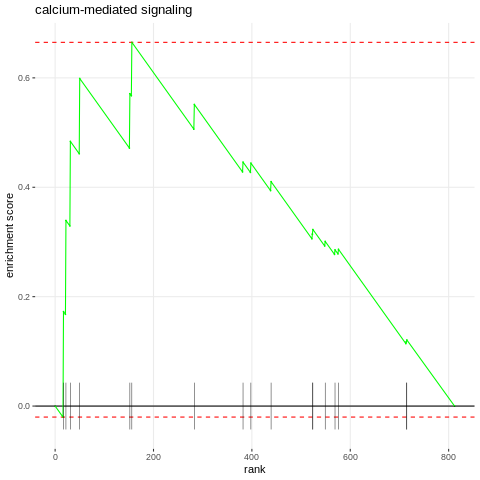

In [86]:
%%R
plotEnrichment(pathways[["GO:0019722"]],
               ranks) + labs(title="calcium-mediated signaling")

The fgsea package also have a gsea table plotting function. I don't think this really provides any additional information not shown in the pandas dataframe. The FDR for both packages is worryingly high. Perhaps this is due to either a very small geneset (there's only around ~600 goprocesses), or a relatively small number of genes with scores. Normally you would run prerank GSEA on the DEGs of a t'omics comparison, and thus would have ~20,000 genes/score pairs.

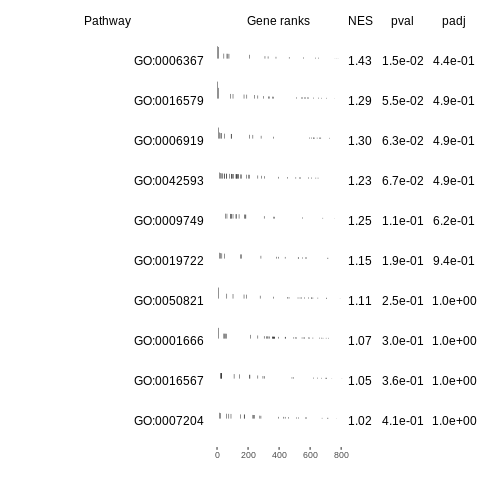

In [94]:
%%R
topPathwaysUp <- old_results[ES > 0][head(order(pval), n=10), pathway]
topPathwaysDown <- old_results[ES < 0][head(order(pval), n=10), pathway]
topPathways <- c(topPathwaysUp, rev(topPathwaysDown))
plotGseaTable(pathways[topPathways], ranks, old_results, 
              gseaParam=0.5)